In [624]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import random
from tensorflow.keras import models, Model
from tensorflow.keras.layers import LSTM, Input, GRU, SimpleRNN, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score


In [625]:
df = pd.read_csv('./data-kiem-tra-2.csv', encoding='latin-1', sep=',')

##### Biến đổi cột 'date' từ type là object sang datetime

In [626]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

In [627]:
df

,date,truong_1,truong_2,truong_3,truong_4,truong_5
0,2013-05-10,4,58,3773,299.0,1
1,2013-05-26,4,58,3768,249.0,1
2,2013-05-19,4,58,4036,419.0,1
3,2013-05-25,4,58,12878,149.0,1
4,2013-05-15,4,58,12885,148.0,1
...,...,...,...,...,...,...
550033,2013-11-07,10,37,18474,199.0,1
550034,2013-11-18,10,37,18474,199.0,1
550035,2013-11-24,10,37,18484,199.0,1
550036,2013-11-11,10,37,19751,99.0,1


##### Loại bỏ những giá trị bị lặp lại theo ngày

In [628]:
df = df.drop_duplicates(subset=['date'])

In [629]:
df

,date,truong_1,truong_2,truong_3,truong_4,truong_5
0,2013-05-10,4,58,3773,299.0,1
1,2013-05-26,4,58,3768,249.0,1
2,2013-05-19,4,58,4036,419.0,1
3,2013-05-25,4,58,12878,149.0,1
4,2013-05-15,4,58,12885,148.0,1
...,...,...,...,...,...,...
529140,2013-11-12,10,28,10298,399.0,2
529150,2013-11-28,10,28,10298,399.0,1
529163,2013-11-26,10,28,9324,589.0,1
529196,2013-11-19,10,28,8944,149.0,1


##### Sắp xếp giá trị theo ngày

In [630]:
df = df.sort_values(by='date')
df.index = np.arange(1, len(df)+1)

In [631]:
df

,date,truong_1,truong_2,truong_3,truong_4,truong_5
1,2013-05-01,4,59,2436,799.0,1
2,2013-05-02,4,59,2739,2299.0,2
3,2013-05-03,4,59,2730,499.0,1
4,2013-05-04,4,59,2738,1839.0,1
5,2013-05-05,4,59,2257,299.0,1
...,...,...,...,...,...,...
210,2013-11-26,10,28,9324,589.0,1
211,2013-11-27,10,28,11030,149.0,1
212,2013-11-28,10,28,10298,399.0,1
213,2013-11-29,10,28,10292,99.0,1


- Dữ liệu sau khi đã xóa các trùng lặp về thời gian chỉ gồm 214 mẫu dữ liệu

##### Biểu đồ heatmap thể hiện sự tương quan giữa các đặc trưng của dữ liệu

In [632]:
data = df.iloc[:, 1:]

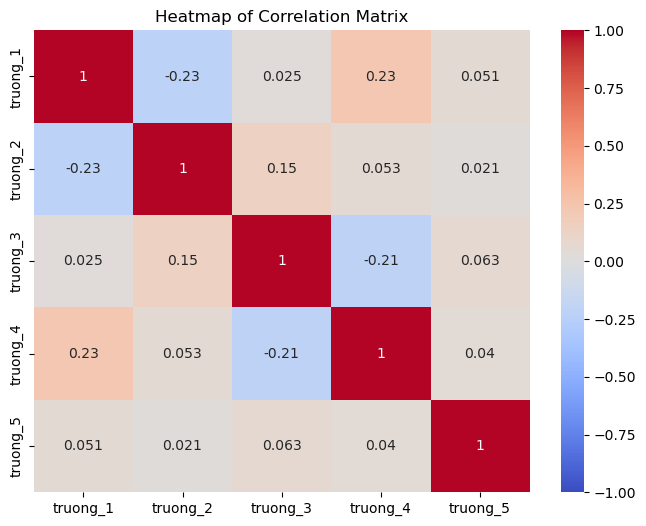

In [633]:
correlation_matrix = data.corr()

# Vẽ biểu đồ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation Matrix')
plt.show()

- Theo như biểu đồ thì các trường không cho thấy có sự tương quan mạnh với nhau

##### Biểu đồ thể hiện các giá trị của trường 1

<Axes: xlabel='truong_1', ylabel='count'>

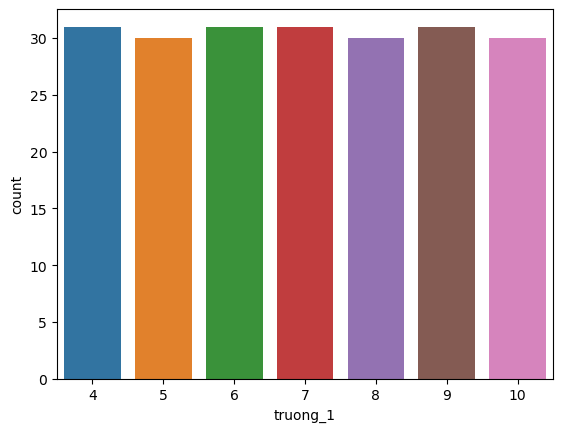

In [634]:
sns.countplot(data=data, x='truong_1')

##### Biều đồ thể hiện các giá trị của trường 2 theo thời gian

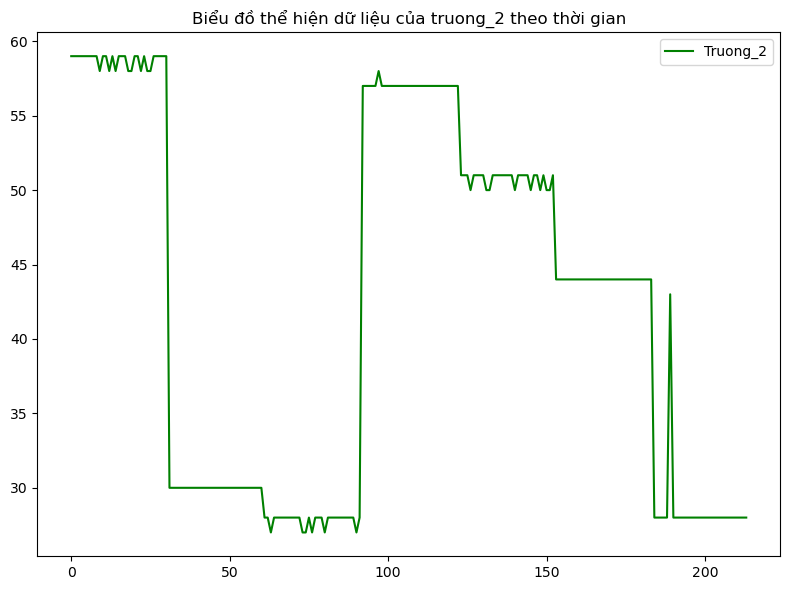

In [635]:
plt.figure(figsize=(8, 6))

plt.plot(range(data['truong_2'].shape[0]), data['truong_2'], 'green', label='Truong_2')
plt.title(f'Biểu đồ thể hiện dữ liệu của truong_2 theo thời gian')
plt.legend()

plt.tight_layout()
plt.show()

##### Biều đồ thể hiện các giá trị của trường 3 theo thời gian

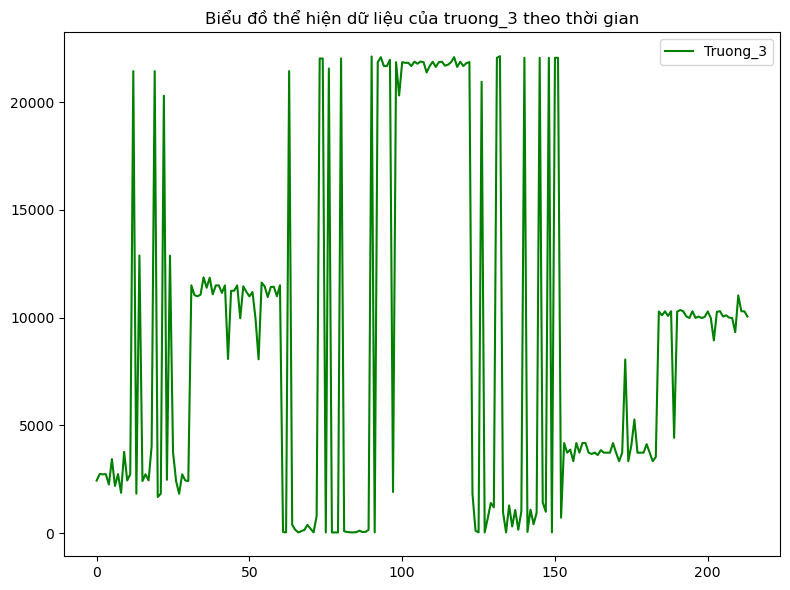

In [636]:
plt.figure(figsize=(8, 6))

plt.plot(range(data['truong_3'].shape[0]), data['truong_3'], 'green', label='Truong_3')
plt.title(f'Biểu đồ thể hiện dữ liệu của truong_3 theo thời gian')
plt.legend()

plt.tight_layout()
plt.show()

##### Biều đồ thể hiện các giá trị của trường 4 theo thời gian

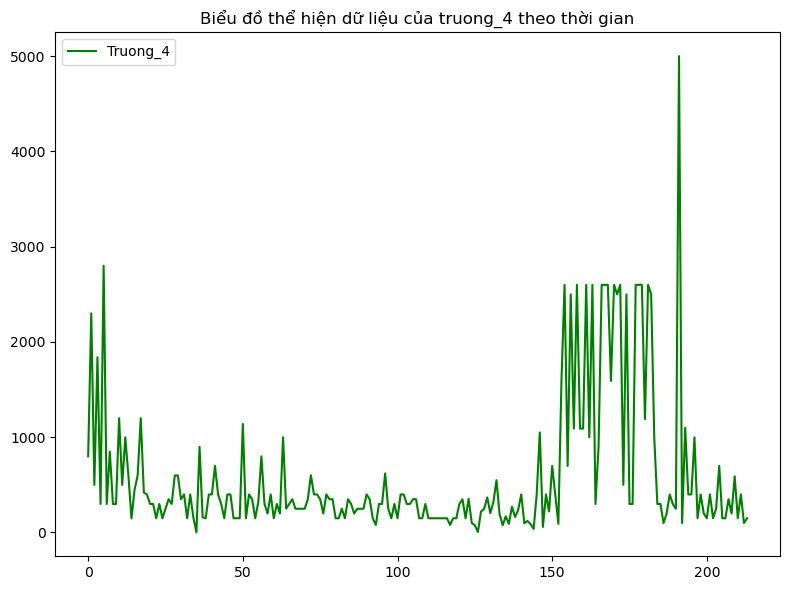

In [637]:
plt.figure(figsize=(8, 6))

plt.plot(range(data['truong_4'].shape[0]), data['truong_4'], 'green', label='Truong_4')
plt.title(f'Biểu đồ thể hiện dữ liệu của truong_4 theo thời gian')
plt.legend()

plt.tight_layout()
plt.show()

##### Biều đồ thể hiện các giá trị của trường 5 theo thời gian

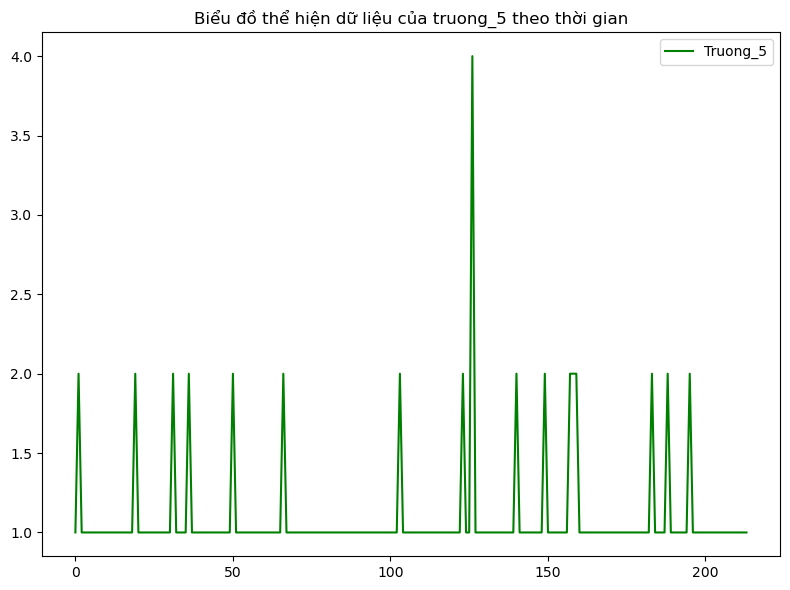

In [638]:
plt.figure(figsize=(8, 6))

plt.plot(range(data['truong_5'].shape[0]), data['truong_5'], 'green', label='Truong_5')
plt.title(f'Biểu đồ thể hiện dữ liệu của truong_5 theo thời gian')
plt.legend()

plt.tight_layout()
plt.show()

### Mô hình Arima, Garch

In [639]:
# Sử dụng test size = 50
TEST_SIZE = 50

- Đánh giá mô hình qua 4 độ đo:
    - R2: Đánh giá mức độ tốt của mô hình hồi quy
    - RMSE: Đánh giá biên độ dao động giữa giá trị dự báo xung quanh giá trị thực tế
    - MAE: Trung bình sai số giữa giá trị dự báo và giá trị thực tế
    - MAPE: Phần trăm lỗi giữa giá trị dự đoán và giá trị thực tế

In [640]:
def measure_metric(y_true, y_pred):
    e = y_true - y_pred
    r2=r2_score(y_true, y_pred)
    mse=np.mean(e**2)
    rmse=np.sqrt(mse)
    mae=np.mean(np.abs(e))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print('R2: {}'.format(r2))
    print('MSE: {}'.format(mse))
    print('RMSE: {}'.format(rmse))
    print('MAE: {}'.format(mae))
    print('MAPE: {}'.format(mape))
    return [r2, mse, rmse, mae, mape]

In [641]:
dict_single_step = {
    'R2': [],
    'MSE': [],
    'RMSE': [],
    'MAE': [],
    'MAPE': []
}

In [642]:
metric_df_single_step = pd.DataFrame(dict_single_step)

In [643]:
data

,truong_1,truong_2,truong_3,truong_4,truong_5
1,4,59,2436,799.0,1
2,4,59,2739,2299.0,2
3,4,59,2730,499.0,1
4,4,59,2738,1839.0,1
5,4,59,2257,299.0,1
...,...,...,...,...,...
210,10,28,9324,589.0,1
211,10,28,11030,149.0,1
212,10,28,10298,399.0,1
213,10,28,10292,99.0,1


In [644]:
df['date'] = pd.to_datetime(df['date'])

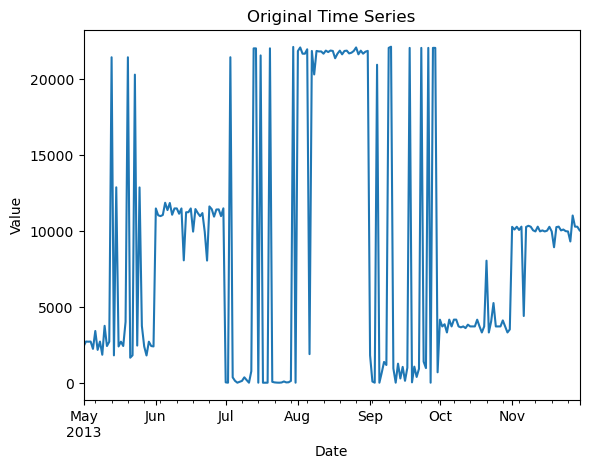

c:\Users\84936\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\84936\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\84936\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\84936\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\84936\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided,

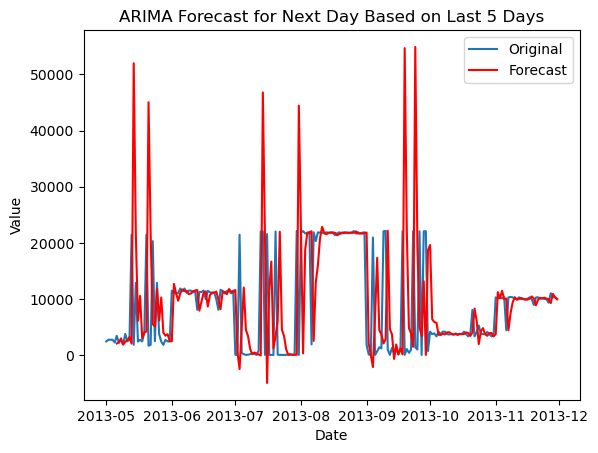

Dự báo cho ngày 2013-11-30 00:00:00 là: 9930.237547174209


In [645]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Đọc dữ liệu vào DataFrame từ tệp CSV
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Vẽ chuỗi thời gian ban đầu
df['truong_3'].plot()
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Chọn các giá trị p, d, q
p = 1  # Số lượng các quan sát trễ
d = 1  # Số lần lấy sai khác để làm tĩnh chuỗi thời gian
q = 1  # Số lượng sai số trễ

# Khởi tạo danh sách lưu trữ các dự báo
forecasts = []

# Lặp qua các khoảng thời gian trong chuỗi dữ liệu
for i in range(5, len(df)):
    # Sử dụng 5 ngày trước đó để dự báo ngày thứ 6
    train_data = df['truong_3'].iloc[i-5:i]
    
    # Tạo mô hình ARIMA
    model = ARIMA(train_data, order=(p, d, q))

    # Huấn luyện mô hình
    model_fit = model.fit()

    # Dự báo giá trị ngày tiếp theo
    forecast = model_fit.forecast(steps=1)
    forecasts.append(forecast[0])

# Vẽ dự báo so với dữ liệu thực tế
forecast_dates = df.index[5:]
plt.plot(df.index, df['truong_3'], label='Original')
plt.plot(forecast_dates, forecasts, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast for Next Day Based on Last 5 Days')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# In dự báo cho ngày cuối cùng
print(f"Dự báo cho ngày {forecast_dates[-1]} là: {forecasts[-1]}")


c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.956e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.412e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33.78177449842695
Iteration:      2,   Func. Count:     12,   Neg. LLF: 33.516524183808365
Iteration:      3,   Func. Count:     17,   Neg. LLF: 33.51652160309196
Iteration:      4,   Func. Count:     21,   Neg. LLF: 33.51652160310451
Optimization terminated successfully    (Exit mode 0)
            Current function value: 33.51652160309196
            Iterations: 4
            Function evaluations: 21
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 36.463778539612086
Iteration:      2,   Func. Count:     11,   Neg. LLF: 36.3643263121401
Iteration:      3,   Func. Count:     16,   Neg. LLF: 36.35211024810018
Iteration:      4,   Func. Count:     21,   Neg. LLF: 36.349007489880876
Iteration:      5,   Func. Count:     26,   Neg. LLF: 36.34775180183681
Iteration:      6,   Func. Count:     31,   Neg. LLF: 36.34768201737266
Iteration:      7,   Func. Count:     36,   Neg. LLF: 36.34764377804605

c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.071e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.776e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

Iteration:      1,   Func. Count:      6,   Neg. LLF: 43.68235888320507
Iteration:      2,   Func. Count:     12,   Neg. LLF: 42.967766405874954
Iteration:      3,   Func. Count:     16,   Neg. LLF: 42.96776640583851
Optimization terminated successfully    (Exit mode 0)
            Current function value: 42.967766405874954
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 43.85472243882385
Iteration:      2,   Func. Count:     12,   Neg. LLF: 42.942200982279374
Iteration:      3,   Func. Count:     17,   Neg. LLF: 42.94200052733042
Iteration:      4,   Func. Count:     21,   Neg. LLF: 42.94200052735063
Optimization terminated successfully    (Exit mode 0)
            Current function value: 42.94200052733042
            Iterations: 4
            Function evaluations: 21
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 34.72583126964228
Iterati

c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 1.789e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.997e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Dat

Iteration:      6,   Func. Count:     32,   Neg. LLF: 21.920268011069126
Iteration:      7,   Func. Count:     37,   Neg. LLF: 21.919318943973696
Iteration:      8,   Func. Count:     42,   Neg. LLF: 21.9191245631907
Iteration:      9,   Func. Count:     47,   Neg. LLF: 21.91910883574618
Iteration:     10,   Func. Count:     52,   Neg. LLF: 21.91910723711691
Iteration:     11,   Func. Count:     57,   Neg. LLF: 21.91910329678331
Iteration:     12,   Func. Count:     62,   Neg. LLF: 21.919093254851774
Iteration:     13,   Func. Count:     67,   Neg. LLF: 21.91906655708498
Iteration:     14,   Func. Count:     72,   Neg. LLF: 21.918997099492287
Iteration:     15,   Func. Count:     77,   Neg. LLF: 21.91881414344963
Iteration:     16,   Func. Count:     82,   Neg. LLF: 21.918334898361913
Iteration:     17,   Func. Count:     87,   Neg. LLF: 21.917059589896795
Iteration:     18,   Func. Count:     92,   Neg. LLF: 21.913640707218075
Iteration:     19,   Func. Count:     97,   Neg. LLF: 21.9

c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.764e+07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.778e+07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Da

Iteration:      1,   Func. Count:      6,   Neg. LLF: 35.90203308131039
Iteration:      2,   Func. Count:     12,   Neg. LLF: 33.04686210117299
Iteration:      3,   Func. Count:     16,   Neg. LLF: 33.04686210119069
Optimization terminated successfully    (Exit mode 0)
            Current function value: 33.04686210117299
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 33.85103860365865
Iteration:      2,   Func. Count:     12,   Neg. LLF: 33.03497107917845
Iteration:      3,   Func. Count:     17,   Neg. LLF: 33.03496835818916
Iteration:      4,   Func. Count:     22,   Neg. LLF: 33.03496689833306
Iteration:      5,   Func. Count:     27,   Neg. LLF: 33.03496361000967
Iteration:      6,   Func. Count:     32,   Neg. LLF: 33.03495451361407
Iteration:      7,   Func. Count:     37,   Neg. LLF: 33.034931418923186
Iteration:      8,   Func. Count:     42,   Neg. LLF: 33.03487203754547


c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.283e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.596e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

Iteration:      3,   Func. Count:     16,   Neg. LLF: 53.37733277497766
Optimization terminated successfully    (Exit mode 0)
            Current function value: 53.37733277495697
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 54.06389603552357
Iteration:      2,   Func. Count:     12,   Neg. LLF: 53.348765416425174
Iteration:      3,   Func. Count:     17,   Neg. LLF: 53.342610602976514
Iteration:      4,   Func. Count:     22,   Neg. LLF: 53.340784835882666
Iteration:      5,   Func. Count:     27,   Neg. LLF: 53.34071229902306
Iteration:      6,   Func. Count:     32,   Neg. LLF: 53.34069987086635
Iteration:      7,   Func. Count:     36,   Neg. LLF: 53.34069987087125
Optimization terminated successfully    (Exit mode 0)
            Current function value: 53.34069987086635
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7
Iterati

c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.129e+07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.145e+07. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Da

Iteration:      4,   Func. Count:     21,   Neg. LLF: 36.182420930454455
Optimization terminated successfully    (Exit mode 0)
            Current function value: 36.182420930459266
            Iterations: 4
            Function evaluations: 21
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 34.18254122987757
Iteration:      2,   Func. Count:     12,   Neg. LLF: 34.03779787428159
Iteration:      3,   Func. Count:     16,   Neg. LLF: 34.03779787431263
Optimization terminated successfully    (Exit mode 0)
            Current function value: 34.03779787428159
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 34.30069428405872
Iteration:      2,   Func. Count:     12,   Neg. LLF: 34.28514006050068
Iteration:      3,   Func. Count:     16,   Neg. LLF: 34.28514006051997
Optimization terminated successfully    (Exit mode 0)
            Current functi

c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.154e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.102e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

Iteration:      1,   Func. Count:      6,   Neg. LLF: 48.41341491539394
Iteration:      2,   Func. Count:     12,   Neg. LLF: 47.61304004194144
Iteration:      3,   Func. Count:     17,   Neg. LLF: 47.592410031023384
Iteration:      4,   Func. Count:     22,   Neg. LLF: 47.59164643065438
Iteration:      5,   Func. Count:     27,   Neg. LLF: 47.59147900305297
Iteration:      6,   Func. Count:     32,   Neg. LLF: 47.59147847620476
Optimization terminated successfully    (Exit mode 0)
            Current function value: 47.59147847620476
            Iterations: 6
            Function evaluations: 32
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      6,   Neg. LLF: 47.29962115380559
Iteration:      2,   Func. Count:     12,   Neg. LLF: 46.385048405692004
Iteration:      3,   Func. Count:     17,   Neg. LLF: 46.38484531239324
Iteration:      4,   Func. Count:     21,   Neg. LLF: 46.384845312405886
Optimization terminated successfully    (Exit mode 0)
            Curr

c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.543e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.44e+06. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.01 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Dat

Iteration:      4,   Func. Count:     21,   Neg. LLF: 37.678199363724715
Optimization terminated successfully    (Exit mode 0)
            Current function value: 37.67819936371957
            Iterations: 4
            Function evaluations: 21
            Gradient evaluations: 4
Iteration:      1,   Func. Count:      6,   Neg. LLF: 38.63905408893108
Iteration:      2,   Func. Count:     12,   Neg. LLF: 38.075177460359946
Iteration:      3,   Func. Count:     16,   Neg. LLF: 38.075177460359996
Optimization terminated successfully    (Exit mode 0)
            Current function value: 38.075177460359946
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3
Iteration:      1,   Func. Count:      6,   Neg. LLF: 38.62291925135768
Iteration:      2,   Func. Count:     12,   Neg. LLF: 38.35358358604967
Iteration:      3,   Func. Count:     16,   Neg. LLF: 38.353583586056665
Optimization terminated successfully    (Exit mode 0)
            Current fun

c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.052e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\84936\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.041e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


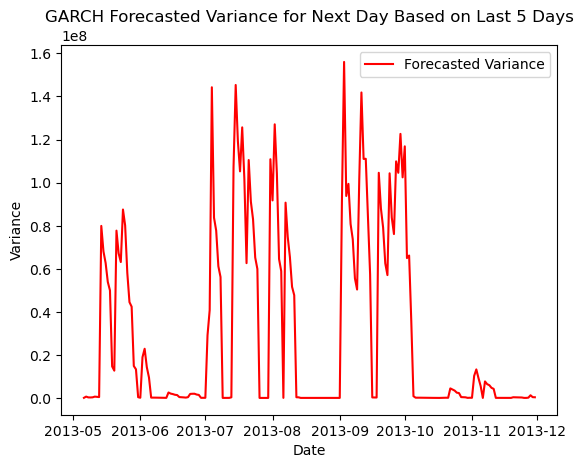

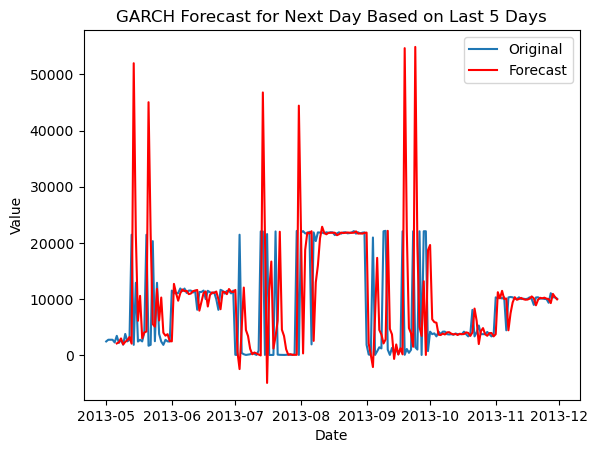

In [649]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model


# Chọn cột dữ liệu và chuyển đổi sang kiểu dữ liệu phù hợp
returns = df['truong_3'].astype(float)

# Chọn các giá trị p, q cho mô hình GARCH
p = 1  # Số lượng lags cho phần GARCH
q = 1  # Số lượng lags cho phần ARCH

# Khởi tạo danh sách lưu trữ các dự báo phương sai
forecast_variances = []

# Lặp qua các khoảng thời gian trong chuỗi dữ liệu
for i in range(5, len(df)):
    # Sử dụng 5 ngày trước đó để huấn luyện mô hình GARCH
    train_data = returns.iloc[i-5:i]
    
    # Xác định mô hình GARCH
    model = arch_model(train_data, vol='Garch', p=p, q=q)
    
    # Huấn luyện mô hình
    model_fit = model.fit()
    
    # Dự đoán phương sai cho ngày thứ 6
    forecast_variance = model_fit.forecast(horizon=1).variance.iloc[-1, -1]
    forecast_variances.append(forecast_variance)

# Hiển thị kết quả dự đoán trên biểu đồ
forecast_dates = df.index[5:]
plt.plot(forecast_dates, forecast_variances, label='Forecasted Variance', color='red')
plt.title('GARCH Forecasted Variance for Next Day Based on Last 5 Days')
plt.xlabel('Date')
plt.ylabel('Variance')
plt.legend()
plt.show()

forecast_dates = df.index[5:]
plt.plot(df.index, df['truong_3'], label='Original')
plt.plot(forecast_dates, forecasts, label='Forecast', color='red')
plt.legend()
plt.title('GARCH Forecast for Next Day Based on Last 5 Days')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()